In [ ]:
"""requirement of the code
-gym
-pytorch
-matplotlib
-numpy
"""

'requirement of the code\n-gym\n-pytorch\n-matplotlib\n-numpy\n'

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import time

In [ ]:
"""Q is a class which builds neural-network with pytorch. 
   This class gets shapes as argument and build nn according to this shape.
   Relu is used as activation function and no activation function is used in last layer as output of neural network should have same domain with the q-function.
   Forward function gets state as input and outputs value of q-function of every action.
"""

'Q is a class which builds neural-network with pytorch. \n   This class gets shapes as argument and build nn according to this shape.\n   Relu is used as activation function and no activation function is used in last layer as output of neural network should have same domain with the q-function.\n   Forward function gets state as input and outputs value of q-function of every action.\n'

In [2]:
class Q(nn.Module):
  def __init__(self, shape):
    super(Q, self).__init__()
    self.layers = nn.Sequential()
    for i in range(len(shape)-1):
        self.layers.add_module(str(i)+"th layer",nn.Linear(shape[i],shape[i+1]))
        if(i != len(shape)-2):
          self.layers.add_module(str(i)+"th nonlinear",nn.ReLU())

  def forward(self, input):
    return self.layers(input)

In [ ]:
"""
ReplayMemory class is an implemenation of replay-memory in dqn algorithm.
ReplayMemory saves experiences like circle-queue.
It memorize the front, the first position to insert the new experience.
When new experence is inserted, replaymemory overwrites the data in front and change the position to (position+1)%capacity.
By this way, replay memory can remove the oldest experience and guarantee there are maximum capacity experience in memory.

sample method returns random sample with size of batch_size.
sample memory reorganize the variables in samples by name and convert it to torch tensor.
and return samples by following order, state, action, reward, next_state, done.
"""

'\nReplayMemory class is an implemenation of replay-memory in dqn algorithm.\nReplayMemory saves experiences like circle-queue.\nIt memorize the front, the first position to insert the new experience.\nWhen new experence is inserted, replaymemory overwrites the data in front and change the position to (position+1)%capacity.\nBy this way, replay memory can remove the oldest experience and guarantee there are maximum capacity experience in memory.\n\nsample method returns random sample with size of batch_size.\nsample memory reorganize the variables in samples by name and convert it to torch tensor.\nand return samples by following order, state, action, reward, next_state, done.\n'

In [3]:
Sample = namedtuple('Sample','state, action, reward, next_state, done')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ReplayMemory:
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = []
    self.position = 0
  
  def push(self, sample):
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = sample
    self.position = (self.position+1)%self.capacity
  
  def sample(self, batch_size):
    samples = random.sample(self.memory, batch_size)
    states = torch.from_numpy(np.vstack([sample.state for sample in samples if sample is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([sample.action for sample in samples if sample is not None])).long().to(device)        
    rewards = torch.from_numpy(np.vstack([sample.reward for sample in samples if sample is not None])).float().to(device)        
    next_states = torch.from_numpy(np.vstack([sample.next_state for sample in samples if sample is not None])).float().to(device)  
    dones = torch.from_numpy(np.vstack([sample.done for sample in samples if sample is not None]).astype(np.uint8)).float().to(device)
    return (states, actions, rewards, next_states, dones)
  
  def __len__(self):
    return len(self.memory)

In [ ]:
"""
DQN class is an implementation of the dqn algorithm.
parameters of the DQN agent can be set by __init__ method.
To train a DQN agent, you can call the train method with the maximum episode and maximum steps of each episode. 
"""

'\nDQN class is an implementation of the dqn algorithm.\nparameters of the DQN agent can be set by __init__ method.\nTo train a DQN agent, you can call the train method with the maximum episode and maximum steps of each episode. \n'

In [4]:

class DQN():
  """
  __init__
	-----------------------
	This is the part where parameters of dqn agent is defined
	Agent gets the name of the environment by argument and loads the environment from the gym.
  Parameters of DQN, like gamma, frequency of updating target network, capacity of replay memory, shape of networks, learning_rate, should be given as arguments of __init__.

  To guarantee that input size and output size of neural network have same size with size of state and number of action,
  size of state is inserted in front of net_shape array and number of action is appended at the end of net_shape array.
  """
  def __init__(self, game_name, batch_size, gamma, target_update_freq, memory_capacity, net_shape, learning_rate):
    self.env = gym.make(game_name)
    self.gamma = gamma
    
    self.memory = ReplayMemory(memory_capacity)

    observation = self.env.reset()
    net_shape.insert(0,len(observation))
    net_shape.append(self.env.action_space.n)

    self.policy_Q = Q(net_shape).to(device)
    self.target_Q = Q(net_shape).to(device)
    self.target_Q.eval()
    self.optimizer = optim.Adam(self.policy_Q.parameters(), lr=learning_rate)

    self.target_update = target_update_freq

    self.batch_size = batch_size
    
    #parameters for epsilon-greedy policy
    self.eps_start = 1
    self.eps_end = 0.005
    self.eps_decay = 0.9995

    self.epsilon = self.eps_start

  """
  epsilon_greedy_policy
  ------------------------
  Epsilon-greedy policy is used during training
  To give enough exploration in the beginning and stable greedy policy at the end, the value of epsilon decays from eps_start to eps_end, by rate of eps_decay. 
  Each parameters are initialized in __init__.
  For every action, epsilon is updated to epsilon_end + (epsilon-epsilon_end)*eps_decay

  Agent selects random action by probability of epsilon
  """
  def epsilon_greedy_policy(self, state):
    r = random.random()
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.epsilon = self.eps_end + (self.epsilon-self.eps_end) * self.eps_decay
    if r > self.epsilon:
      with torch.no_grad():
        return self.policy_Q(state).max(1)[1].item()
    else:
      return random.randrange(self.env.action_space.n)
  
  """
  update_policy_network
  ------------------------
  policy_network is updated when there are more samples than batch_size in replay memory 
  It loads batch_size number of sample from replay memory.
  Than calculate the target value of samples, with bellman equation.
  The Q value used in bellman equation si obtained from target network

  Than updated policy network in a way to minimize the mse error between predicted q value and target q value.
  """
  def update_policy_network(self):
      if len(self.memory) < self.batch_size:
        return
      states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
      max_action_values = self.target_Q(next_states).detach().max(1)[0].unsqueeze(1)
      q_target = rewards + (self.gamma*max_action_values*(1-dones)).to(device)
      q_expected = self.policy_Q(states).gather(1,actions).to(device)

      loss = F.mse_loss(q_expected, q_target)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
  
  """
  update_target_network
  ------------------------
  target_network is updated by copying the value of parameters in policy network.
  """
  def update_target_network(self):
    for policy_parameters, target_parameters in zip(self.policy_Q.parameters(), self.target_Q.parameters()):
      target_parameters.data.copy_(policy_parameters.data)
  
  """
  train
  ------------------------
  Train method trains agent max_episodes number of episode, which is given as argument.
  And terminate each episode after max_steps of action is made.

  At the beginning of each episode, environment is initialized with reset() method.
  For each loop, action is selected based on epsilon_greedy_policy.
  Then agent take action to environment by step method, which return updated state, reward, and whether environment is finished.
  Experience is composed of (state, action, reward, next_state, done). Experience is saved as namedtuple Sample.
  Each experience is saved to memory of agent.

  Then agent update policy network, and for each target_update_freq episode, target network is updated to poilcy network.
  State is updated to next_state and if environment is doned, agent saves total_reward and whether this episode is succeed.

  Agent repeat this till number of step taken is equals to max_steps.
  To check agent is training properly, train method prints average rewards and number of succeed episode for every 100 episode.

  Train method return history of training.
  """
  def train(self, max_episodes, max_steps):
    start = time.time()
    rewards = [] #array that saves reward agent had achieved for each episode
    succ_episode = [] #array that saves whether each episode had succeed.
    print_interval = 100 #frequency of printing average reward and number of succeed episode.
    for episode in range(1,1+max_episodes):
      state = self.env.reset()
      total_reward = 0
      for t in range(max_steps):
        action = self.epsilon_greedy_policy(state)
        next_state, reward, done, _ = self.env.step(action)
        sample = Sample(state, action, reward, next_state, done)
        self.memory.push(sample)


        self.update_policy_network()
        if t % self.target_update == 0:
          self.update_target_network()

        state = next_state
        total_reward += reward
        
        if done:
          succ_episode.append(1 if t != max_steps-1 else 0)
          rewards.append(total_reward)
          break

      if episode % print_interval == 0:
        print(f"{episode}th episode : {np.mean(rewards[episode-print_interval:])} "+f"probability of success : {np.mean(succ_episode[episode-print_interval:])}"+"  time : "+str(time.time()-start))
    return rewards, succ_episode

Plotting the learning-curve of the agent
To see accurate performance of agent, I trained multiple agent and average the reward. To see the stability of learning, i also plotted stadard deviation on the graph.(green part)

In [ ]:
"""
To check the accurate performance of agent, I trained multiple agent and check the average reward.
I plotted average rewards for each episode as blue line, and deviation of rewards as green area.
Therefore we can see average performance and how stable the learning was by this learning curve graph.
""" 

100th episode : -200.0 probability of success : 0.0  time : 76.69253635406494
200th episode : -177.88 probability of success : 0.47  time : 145.80007219314575
300th episode : -126.78 probability of success : 1.0  time : 194.45845222473145
400th episode : -117.48 probability of success : 0.99  time : 239.50363683700562
500th episode : -132.6 probability of success : 0.88  time : 290.2389659881592
100th episode : -200.0 probability of success : 0.0  time : 75.95390176773071
200th episode : -160.43 probability of success : 0.73  time : 138.154461145401
300th episode : -120.91 probability of success : 0.99  time : 185.67389965057373
400th episode : -109.1 probability of success : 1.0  time : 228.49688863754272
500th episode : -111.2 probability of success : 0.99  time : 272.07356429100037
100th episode : -199.24 probability of success : 0.01  time : 77.30425095558167
200th episode : -190.64 probability of success : 0.23  time : 152.4882435798645
300th episode : -139.69 probability of succe

Text(0.5, 1.0, 'Performance of DQN Agent')

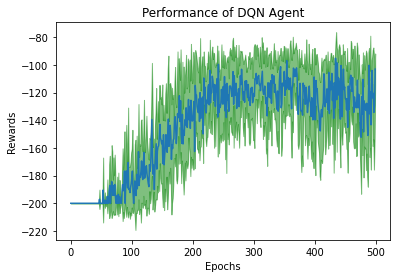

In [5]:
agent_number = 7

all_rewards = np.zeros((500, agent_number))
all_success = np.zeros((500, agent_number))

for t in range(agent_number) :
    Agent = DQN('MountainCar-v0', 32, 0.99, 100, 10000, [256, 128], 0.005)
    rewards, success = Agent.train(500, 200)
    for i in range(len(rewards)) :
        all_success[i, t] = success[i]
        all_rewards[i, t] = rewards[i]

mean1 = np.mean(all_rewards, axis = 1)
std1 = np.std(all_rewards, axis = 1)
plt.plot(range(len(all_rewards)), mean1)
plt.fill_between(range(len(all_rewards)), mean1-std1, mean1+std1, color = 'g', alpha = 0.5)
plt.xlabel('Epochs')
plt.ylabel('Rewards')
plt.title('Performance of DQN Agent')

Ablation of target network by setting target_update_freq = 1


100th episode : -194.45 probability of success : 0.14  time : 75.74018239974976
200th episode : -152.55 probability of success : 0.78  time : 136.61182928085327
300th episode : -163.35 probability of success : 0.78  time : 201.77985191345215
400th episode : -155.51 probability of success : 0.78  time : 262.91036319732666
500th episode : -154.13 probability of success : 0.83  time : 323.59389090538025
100th episode : -200.0 probability of success : 0.0  time : 77.22764825820923
200th episode : -192.0 probability of success : 0.24  time : 152.51292610168457
300th episode : -171.21 probability of success : 0.58  time : 220.01332926750183
400th episode : -190.37 probability of success : 0.23  time : 296.74973607063293
500th episode : -181.19 probability of success : 0.41  time : 369.2828869819641
100th episode : -200.0 probability of success : 0.0  time : 78.20256447792053
200th episode : -175.7 probability of success : 0.49  time : 147.6806468963623
300th episode : -182.64 probability of 

Text(0.5, 1.0, 'Performance of DQN Agent')

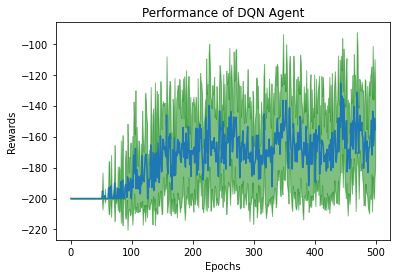

In [ ]:
agent_number = 7

all_rewards = np.zeros((500, agent_number))
all_success = np.zeros((500, agent_number))

for t in range(agent_number) :
    Agent = DQN('MountainCar-v0', 32, 0.99, 1, 10000, [256, 128], 0.005)
    rewards, success = Agent.train(500, 200)
    for i in range(len(rewards)) :
        all_success[i, t] = success[i]
        all_rewards[i, t] = rewards[i]

mean1 = np.mean(all_rewards, axis = 1)
std1 = np.std(all_rewards, axis = 1)
plt.plot(range(len(all_rewards)), mean1)
plt.fill_between(range(len(all_rewards)), mean1-std1, mean1+std1, color = 'g', alpha = 0.5)
plt.xlabel('Epochs')
plt.ylabel('Rewards')
plt.title('Performance of DQN Agent')

100th episode : -184.01 probability of success : 0.21  time : 69.2271671295166
200th episode : -130.99 probability of success : 0.96  time : 119.0242977142334
300th episode : -139.97 probability of success : 0.86  time : 172.35669445991516
400th episode : -124.54 probability of success : 0.97  time : 220.03809428215027
500th episode : -132.12 probability of success : 0.92  time : 270.6078746318817
100th episode : -169.89 probability of success : 0.46  time : 63.564045906066895
200th episode : -145.3 probability of success : 0.84  time : 117.81878733634949
300th episode : -131.65 probability of success : 0.97  time : 167.8592278957367
400th episode : -179.79 probability of success : 0.39  time : 236.63625741004944
500th episode : -186.02 probability of success : 0.27  time : 307.4846713542938
100th episode : -193.87 probability of success : 0.12  time : 72.43014097213745
200th episode : -129.92 probability of success : 0.95  time : 121.76324009895325
300th episode : -116.82 probability 

Text(0.5, 1.0, 'Performance of DQN Agent')

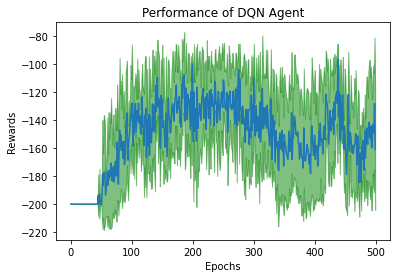

In [ ]:
agent_number = 7

all_rewards = np.zeros((500, agent_number))
all_success = np.zeros((500, agent_number))

for t in range(agent_number) :
    Agent = DQN('MountainCar-v0', 32, 0.99, 100, 1000, [256, 128], 0.005)
    rewards, success = Agent.train(500, 200)
    for i in range(len(rewards)) :
        all_success[i, t] = success[i]
        all_rewards[i, t] = rewards[i]

mean1 = np.mean(all_rewards, axis = 1)
std1 = np.std(all_rewards, axis = 1)
plt.plot(range(len(all_rewards)), mean1)
plt.fill_between(range(len(all_rewards)), mean1-std1, mean1+std1, color = 'g', alpha = 0.5)
plt.xlabel('Epochs')
plt.ylabel('Rewards')
plt.title('Performance of DQN Agent')